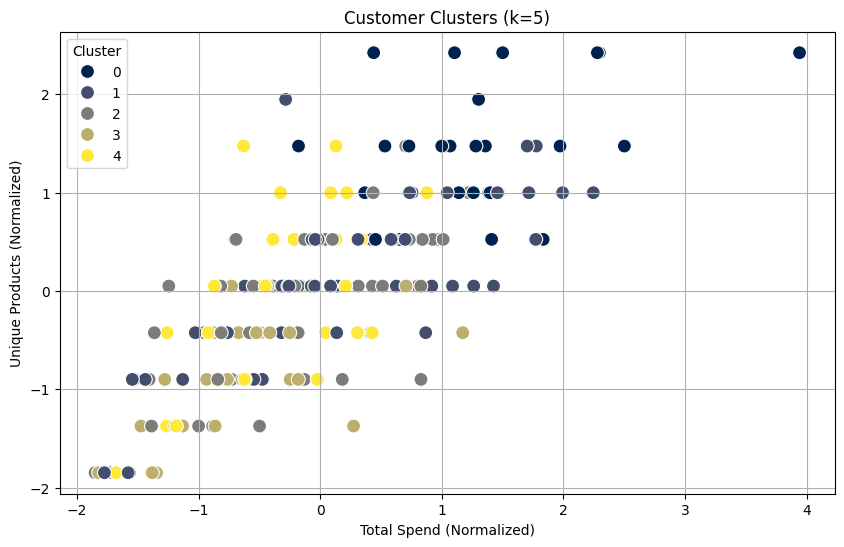

Number of Clusters: 5
Davies-Bouldin Index: 0.8233
Silhouette Score: 0.4892


In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Feature Engineering
# Aggregate transaction data for clustering
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',                  # Total transaction value
    'ProductID': 'nunique',               # Number of unique products purchased
    'TransactionDate': 'count'            # Number of transactions
}).rename(columns={
    'TotalValue': 'TotalSpend',
    'ProductID': 'UniqueProducts',
    'TransactionDate': 'TransactionCount'
}).reset_index()

# Add demographic information (Region encoded)
region_dummies = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'])
customer_features = customer_features.merge(region_dummies, on='CustomerID')

# Normalize the features
scaler = StandardScaler()
features_to_normalize = customer_features.drop(columns=['CustomerID']).columns
customer_features[features_to_normalize] = scaler.fit_transform(customer_features[features_to_normalize])

# Drop CustomerID for clustering
clustering_data = customer_features.drop(columns=['CustomerID'])

# Perform K-Means Clustering
num_clusters = 5  # Choose number of clusters (between 2 and 10)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(clustering_data)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(clustering_data, customer_features['Cluster'])
silhouette_avg = silhouette_score(clustering_data, customer_features['Cluster'])

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=clustering_data['TotalSpend'],
    y=clustering_data['UniqueProducts'],
    hue=customer_features['Cluster'],
    palette='cividis',
    s=100
)
plt.title(f'Customer Clusters (k={num_clusters})')
plt.xlabel('Total Spend (Normalized)')
plt.ylabel('Unique Products (Normalized)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Save clustering results
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)

# Print Clustering Metrics
print(f"Number of Clusters: {num_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
